# Astronomy using Scikitlearn
references:http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/tutorial/astronomy/index.html

## 2. Dimensionality Reduction
The Sloan Digital Sky Survey is a photometric and spectroscopic survey which has operated since the year 2000, and has resulted in an unprecedented astronomical database. The database contains photometric observations like those we explored in the previous sections, but also includes a large number of spectra of various objects. These spectra are essentially 4000-dimensional data vectors for each observed object, where each observation gives the flux of a particular wavelength of light.

Because of the large dimensionality of this data, visualization of the dataset becomes very challenging. This is where unsupervised dimensionality reduction methods can be useful. One of the most commonly used dimensionality reduction methods in astronomy is Principal Component Analysis (PCA). We won’t go through the mathematical details here, but PCA essentially seeks dimensions of the input data which contain the bulk of the variability present in the data. The model has this form:

$\vec{x_i} = \vec{\mu} + \sum_{j = 1}^n a_{ij} \vec{v_j}$

Here $\vec{x_i}$ represents an individual spectrum. $\vec{\mu}$ is the mean spectrum for the dataset. The remaining term encodes the contributions of each of the eigenvectors $\vec{v_j}$. The eigenvectors are generally arranged so that those with the smallest j contain the most signal-to-noise, and are the most important vectors in reconstructing the spectra. For this reason, truncating the sum at some $ m < n $ can still result in a faithful representation of the input.

For astronomical spectra, the result is that the first few coefficientts $a_{ij}$ of each spectrum $\vec{x_i}$ encode a good low-dimensional representation of the spectrum. We’ll use this fact to visualize this data in a meaningful way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=np.load('spec4000_corrected.npz')

In [6]:
data.files

['spectra', 'wavelengths', 'classifiers', 'labels']

The  contains 4000 spectra, each with 1000 attributes. In addition, the file includes a classification code 'classifiers' which can be decoded using 'labels' which contain the actual labels for the encoded classifiers, and an array wavelengths which can aid in plotting spectra. Let’s plot a few of these to see what they look like, making sure to choose a representative of each of the interesting classes:

In [7]:
labels=data['labels']
X = data['spectra']
wavelengths = data['wavelengths']
y=data['classifiers']

Text(0.5, 1.0, 'Sample of Spectra')

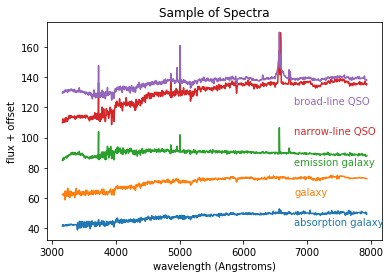

In [9]:
for i_class in (2, 3, 4, 5, 6): #these numbers represent different classes
    i = np.where(y == i_class)[0][0]
    l = plt.plot(wavelengths, X[i] + 20 * i_class)
    c = l[0].get_color()
    plt.text(6800, 2 + 20 * i_class, labels[i_class], color=c)

plt.subplots_adjust(hspace=0)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('flux + offset')
plt.title('Sample of Spectra')

There are 4000 spectra in this file, each with 1000 attributes. Visualizing a dataset of this size can be very difficult. We could plot all 4000 spectra as we did above, but the plot would quickly become too complicated. As a first step, it might be helpful to ask what the average spectrum looks like. To do this, we’ll plot the mean, but first we’ll normalize the spectra. Because the spectra represent galaxies at distances that range over several hundreds of light-years, their total flux varies greatly. Thus it will help if we normalize the spectra. For this we’ll use the scikit-learn preprocessing module. We’ll then plot both the mean and standard deviation to give us an idea of the data we’re working with:

Text(0.5, 1.0, 'Mean Spectrum')

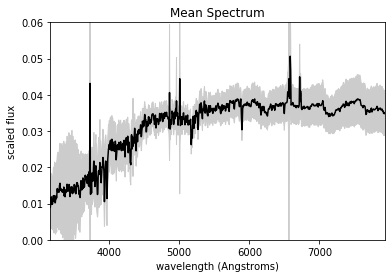

In [11]:
from sklearn import preprocessing
X = preprocessing.normalize(X)
mu = X.mean(0)
std = X.std(0)
plt.plot(wavelengths, mu, color='black')
plt.fill_between(wavelengths, mu - std, mu + std, color='#CCCCCC')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0, 0.06)
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('scaled flux')
plt.title('Mean Spectrum')

The mean and standard deviation of the normalized spectra. Some of the largest variation is found at wavelengths at which Hydrogen absorbs and emits photons (Hydrogen is by far the most abundant atom in the universe). For example, the line at 6563 is known as Hydrogen-\alpha, and is often seen in emission (spiking up) in quasars and other active galaxies.

The interesting part of the data is in the gray shaded regions: how do spectra vary from the mean, and how can this variation tell us about their physical properties? One option to visualize this would be to scatter-plot random pairs of observations from each spectrum. We’ll first create a formatter object to make the colorbar labels pretty:

In [12]:
from matplotlib.ticker import FuncFormatter
format = FuncFormatter(lambda i, *args: labels[i].replace(' ', '\n'))

Text(0.5, 1.0, 'Random Pair of Spectra Bins')

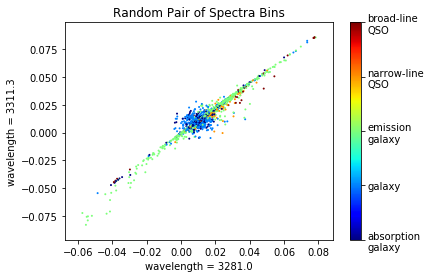

In [23]:
plt.figure()
np.random.seed(25255)  # this seed is chosen to emphasize correlation
i1, i2 = np.random.randint(1000, size=2)
plt.scatter(X[:, i1], X[:, i2], c=y, s=4, lw=0, vmin=2, vmax=6, cmap=plt.cm.jet)
plt.colorbar(ticks = range(2, 7), format=format)
plt.xlabel('wavelength = {:.1f}' .format(wavelengths[i1]))
plt.ylabel('wavelength = {:.1f}'.format(wavelengths[i2]))
plt.title('Random Pair of Spectra Bins')

There is a clear correlation between these two measurements. That is, if you know the value of one, then you could quite accurately predict the value of the other. This shows us that some of the spectral bins do not add much information, and can be ignored. One could imagine proceeding by trial and error, plotting pairs of points and seeing which ones provide the most interesting information, but this would be very tedious. Instead, we can use an automated technique for dimensionality reduction, one well-known example of which is Principal Component Analysis.

### 2.2 Principal Component Analysis
Principal Component Analysis (PCA) is an often-used tool in astronomy and other data-intensive sciences. In a sense, it automates the trial-and-error process discussed in the previous section, and finds the most interesting linear combinations of attributes, so that high-dimensional data can be visualized in a 2D or 3D plot. Scikit-learn has methods to compute PCA and several variants. Classic PCA (sklearn.decomposition.PCA) is based on an eigenvalue decomposition of the data covariance, so that for N points, the computational cost grows as $\mathcal{O}[N^3]$. This means that for large datasets like the current one, the fit can be very slow. You can try it as follows, but the computation may take up to several minutes for this dataset:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_projected = pca.fit_transform(X)  # warning: this takes a long time!

Fortunately, scikit-learn has an alternative method that is much faster. The speed comes at a price: it is based on random projections, so the results are not as robust as the normal method. But for tasks such as ours where we are seeking only a few of a large number of eigenvectors, it performs fairly well. To keep our results consistent between runs, we’ll explicitly set the random seed for the fit. You should repeat this with several different random seeds to convince yourself that the results are consistent. Also, because these spectra have a wide range in:

In [1]:
from sklearn.decomposition import RandomizedPCA
rpca = RandomizedPCA(n_components=4, random_state=0)
X_proj = rpca.fit_transform(X)
X_proj.shape

ImportError: cannot import name 'RandomizedPCA' from 'sklearn.decomposition' (C:\Users\saris\anaconda3\lib\site-packages\sklearn\decomposition\__init__.py)